In [79]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from typing import List
from tqdm import tqdm
from collections import defaultdict

# Can We Forecast the Stock Market Using Only Closing Prices?

Stock price data is everywhere online, meaning opening, closing, high, low, volume, and a bunch of indicators based on them. It’s free and easy to get. On the other hand, other types of data that could be useful for forecasting, like financial statements or market sentiment, are often harder to find, and can be really (sometimes really) expensive.

Because of that, a lot of people have tried to predict the stock market using just price data, especially the closing price. You can find plenty of articles showing models that seem to do a good job, with predicted prices that look very close to the actual ones. But in many cases, these articles don’t include proper evaluation, even basic metrics like MAE or MSE are often missing.

So that got me thinking: Can we actually forecast stock prices using only past prices? In this article, I’ll try to answer that by testing some of the popular models floating around online and evaluating them using a simple (but honest) approach.

If you’re curious or want to dig into the details, everything’s available on [Github](https://github.com/yoest/estytech-labs/blob/master/can-we-forecast-closing-price/code.ipynb). I didn’t include the import statements here to keep things clean, but you’ll find all the code, data, and setup over there.

## What data am I using?

Stock price data is easy to find online, so feel free to use whatever source you prefer. For this article, I’m using a dataset I’ve already parsed and cleaned. It includes 17,610 rows of data from 10 well-known companies, covering the period from January 1, 2018 to January 1, 2025.

In [80]:
df = pd.read_csv('data.csv', index_col=0)
df.head()

,symbol,date,close
0,AAPL,2024-12-31,250.42
1,AAPL,2024-12-30,252.20
2,AAPL,2024-12-27,255.59
3,AAPL,2024-12-26,259.02
4,AAPL,2024-12-24,258.20


I’m framing this as a time series problem, where the input (X) is just the past closing prices, and the target is the return over the next x days. Why use return instead of the price itself? Mainly because prices can vary a lot between companies: a $10 stock and a $1,000 stock behave very differently in raw numbers. Using returns helps normalize things across the board.

Here’s the code I used to create the time series data:

In [81]:
def prepare_supervised_return_data(df: pd.DataFrame, window_size: int = 60, forecast_horizon: int = 10):
    df = df.copy()
    df.sort_values(by=['symbol', 'date'], inplace=True)  # Make sure data is sorted chronologically by stock

    output = []

    # Loop over each unique stock symbol
    for symbol in df['symbol'].unique():
        stock_df = df[df['symbol'] == symbol].reset_index(drop=True)

        # Loop over the time series, leaving space at the beginning for the window, and at the end for the forecast horizon
        for i in range(window_size, len(stock_df) - forecast_horizon):
            row = {
                'symbol': symbol,
                'date': stock_df.loc[i, 'date'],
                'price': stock_df.loc[i, 'close']
            }

            # Extract the past `window_size` closing prices as input
            input_seq = stock_df.loc[i - window_size:i - 1, 'close'].values

            # Standardize the input sequence (zero mean, unit variance)
            input_seq = (input_seq - np.mean(input_seq)) / np.std(input_seq)

            if np.isnan(input_seq).any():
                continue  # Skip this row if normalization produced NaNs

            # Add each normalized return as a feature
            for j in range(window_size):
                row[f'ret_t-{window_size - j}'] = input_seq[j]

            # Compute the return over the next `forecast_horizon` days as the target
            target_price = stock_df.loc[i + forecast_horizon, 'close']
            current_price = stock_df.loc[i, 'close']
            target = (target_price - current_price) / current_price

            if pd.isna(target):
                continue  # Skip if target is NaN

            row['target'] = target

            output.append(row)

    # Create a final DataFrame with all time series samples
    res_df = pd.DataFrame(output)
    res_df.sort_values(by=['date'], inplace=True)
    return res_df.reset_index(drop=True)

As you can see, the standardization is done within each input sequence. This helps address the issue I mentioned earlier about different price scales across companies. Feel free to experiment with the parameters if you’d like. This setup is meant to be a simple, solid starting point.

I chose a 10-day forecast horizon because it strikes a nice balance: it’s not so short that the prediction is trivial, but not so long that it becomes unrealistic either.

In [82]:
sup_df = prepare_supervised_return_data(df)
sup_df.head(10)

,symbol,date,price,ret_t-60,ret_t-59,ret_t-58,ret_t-57,ret_t-56,ret_t-55,ret_t-54,...,ret_t-9,ret_t-8,ret_t-7,ret_t-6,ret_t-5,ret_t-4,ret_t-3,ret_t-2,ret_t-1,target
0,AAPL,2018-03-29,167.78,-0.000768,-0.005535,0.121584,0.434614,0.331330,0.328152,0.321796,...,0.914487,0.482283,0.472749,-0.158077,-0.542612,-1.163904,0.080270,-0.623650,-0.919201,0.041423
1,BABA,2018-03-29,183.54,-0.681289,-0.630759,-0.383884,0.336530,0.283113,0.350967,0.205152,...,1.719610,0.889473,1.527595,1.000639,-0.536918,-1.035000,0.307656,-0.935383,-1.365610,-0.062657
2,MSFT,2018-03-29,91.27,-1.998742,-1.853458,-1.577419,-1.185153,-1.152464,-1.174256,-1.319540,...,1.143020,0.521932,0.609102,0.373016,-0.604017,-1.551994,0.845189,-0.720245,-0.749301,0.019831
3,NFLX,2018-03-29,295.35,-1.848054,-1.744110,-1.728963,-1.615096,-1.561296,-1.632855,-1.549021,...,1.217483,1.087685,1.192673,1.166034,0.910616,0.760186,1.267104,0.753657,0.364001,0.055189
4,AMZN,2018-03-29,1447.34,-2.105777,-1.972996,-1.925880,-1.754987,-1.600003,-1.549040,-1.534792,...,1.239273,1.005443,1.368908,1.328260,1.005355,0.573882,1.100985,0.586907,0.013213,-0.011435
5,NVDA,2018-03-29,231.59,-3.036258,-1.919891,-1.824591,-1.670580,-1.108993,-1.114098,-0.966043,...,1.314341,0.507698,1.237761,1.150970,0.580023,-0.175567,0.803807,-0.809480,-1.164301,-0.000389
6,ORCL,2018-03-29,45.75,-1.528048,-1.004173,-0.776191,-0.635521,-0.388136,-0.349330,-0.475448,...,1.207741,1.052519,-1.324319,-1.338871,-1.886999,-2.420575,-1.600808,-2.134384,-2.328411,0.007213
7,AMD,2018-03-29,10.05,-1.254891,-0.466695,0.321501,-0.010371,0.542749,-0.093339,0.100253,...,-0.577319,-0.632631,-1.075127,-0.867707,-1.351687,-1.738871,-2.001603,-2.610035,-2.872767,-0.011940
8,TSLA,2018-03-29,266.13,-0.580780,-0.762859,-0.908856,-0.800052,0.300750,0.149757,0.211376,...,-0.535260,-0.967699,-1.134790,-0.802828,-1.215282,-1.634953,-1.488401,-2.876200,-4.064157,0.128546
9,GOOGL,2018-03-29,1037.14,-0.800110,-0.402805,-0.310802,0.004481,0.089540,0.058728,0.001226,...,0.528072,-0.217281,-0.309934,-0.348992,-1.235387,-1.812574,-1.214990,-2.238087,-2.276277,-0.001061


The last step is to split our features (X) and targets (y) into the usual datasets: training, validation, and test.

In [83]:
# Define feature columns (lagged returns)
ret_cols = [col for col in sup_df.columns if col.startswith('ret_t')]
X = sup_df[ret_cols].values
y = sup_df['target'].values

# Train/val/test split (time-based)
n = len(sup_df)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

## Does the data need standardization?

We already standardize each input sequence to handle the price scale differences I mentioned earlier. But what about standardizing the data across sequences, is that necessary too? We can check this easily by plotting the mean and variance before and after scaling, like this:

In [84]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

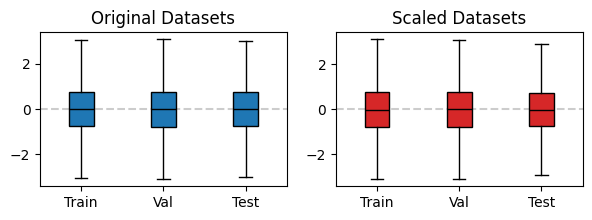

In [85]:
def plot_boxplot(ax, data: dict, title: str, color: str = 'tab:blue'):
    # Draw a horizontal dashed line at 0 for reference
    ax.axhline(0, color='black', linestyle='--', alpha=0.2)
    
    # Create a boxplot for the given data (dictionary of arrays)
    boxplot = ax.boxplot(data.values(), patch_artist=True, showmeans=False, showfliers=False)
    
    # Set the color of each box to blue and the median line color to black for visibility
    for patch, color in zip(boxplot['boxes'], [color] * 3):
        patch.set_facecolor(color)
    for median in boxplot['medians']:
        median.set(color='black')
    
    ax.set_xticklabels(data.keys())
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))

# Original (unscaled) data
data = { 'Train': X_train.reshape(-1), 'Val': X_val.reshape(-1), 'Test': X_test.reshape(-1) }
plot_boxplot(axs[0], data, 'Original Datasets')

# Scaled data
data_scaled = { 'Train': X_train_scaled.reshape(-1), 'Val': X_val_scaled.reshape(-1), 'Test': X_test_scaled.reshape(-1) }
plot_boxplot(axs[1], data_scaled, 'Scaled Datasets', color='tab:red')

plt.show()

As you can see, it’s (pretty much as expected) not really necessary. But at least now you have some code handy if you want to try it out yourself.

## Time to Run Some Models

Now for the fun part: forecasting! But before we jump in, let’s set up all the models we’ll need. I’m a big fan of Object-Oriented Programming, so we’ll start by creating some classes to keep things organized.

### Our Base Classes

Since some models require a PyTorch dataset, we’ll create a simple one using our X and y data.

In [86]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

Now let’s look at our base class. You can think of it like a blueprint for all the models we’ll use. It helps keep things simple and organized. Basically, the class just needs to handle three things: predicting from input, training if needed, and evaluating how well it did.

For evaluation, we’ll keep it simple with MAE, MSE, and RMSE. But since we’re dealing with stock forecasting, I also added a little custom metric: it checks if the predicted and actual returns have the same sign. If yes, it counts as 1, if not, 0. Then we average this over the test set. It’s a neat way to measure if the model got the direction right, which, in stock trading, is often as important as the exact price.

In [87]:
class Model:
    
    def __init__(self, name: str):
        self.name = name
        self.abbr = ''.join([c for c in name if c.isupper()]) if len(name) > 10 else name
        self.model = None  # Placeholder for the actual model instance
        
    def predict(self, X, as_numpy=True):
        # This method should be implemented by subclasses
        raise NotImplementedError("Subclasses should implement this method.")
    
    def train(self, X_train, y_train, X_val, y_val):
        # Optional method to train the model (if applicable). Default implementation does nothing
        pass
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return self.compute_metrics(y_test, y_pred)
        
    def compute_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        
        # Custom metric: fraction of times the predicted and true values have the same sign
        correct_direction = np.mean(np.sign(y_true) == np.sign(y_pred))
        
        return {
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "corr_dir": correct_direction
        }

Some models use PyTorch, while others don’t. To keep training and evaluation simple for the PyTorch ones, let’s create a dedicated PyTorch model class.

In [88]:
class PytorchModel(Model):
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, epochs: int = 10, batch_size: int = 32):
        # Prepare training dataset and dataloader with shuffling
        train_dataset = TimeSeriesDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Prepare validation dataset and dataloader without shuffling
        val_dataset = TimeSeriesDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train_loss, val_loss = 0, 0
            
            self.model.train()
            
            # Loop over training batches
            for inputs, targets in train_loader:
                self.optimizer.zero_grad() 
                
                outputs = self.predict(inputs, as_numpy=False)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                
                # Accumulate training loss for reporting
                train_loss += loss.item()
                
            self.model.eval()
            with torch.no_grad():
                # Loop over validation batches
                for inputs, targets in val_loader:
                    outputs = self.predict(inputs, as_numpy=False)
                    loss = self.criterion(outputs, targets)
                    val_loss += loss.item()
                
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")
            
    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray):
        # Prepare test dataset and dataloader without shuffling
        test_dataset = TimeSeriesDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        self.model.eval()
        y_true, y_pred = [], []
        
        with torch.no_grad():
            # Loop over test batches
            for inputs, targets in test_loader:
                outputs = self.predict(inputs, as_numpy=False)
                
                y_true.append(targets.numpy())
                y_pred.append(outputs.numpy())
        
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        return self.compute_metrics(y_true, y_pred)


### What Models Am I Using?

We’ll be trying out 6 models, ranging from the very simple to the more advanced. These are the kinds you’ll often see in online articles: a naive baseline, linear regression, random forest, an MLP, an LSTM, and a transformer-based model. I won’t dive into the inner workings of each one here (there are tons of great explanations out there, or just ask ChatGPT), but we’ll see how they perform on our task.

Let’s start with a naive model. It simply assumes that the best prediction is no change at all, that the price will stay the same. Sure, it sounds trivial, but it’s actually a really useful baseline. If more complex models don’t outperform this one, it’s a good sign that something might be off in how we’re approaching the problem.

In [89]:
class NaiveModel(Model):
    
    def __init__(self):
        super().__init__("Naive")
        
    def predict(self, X: np.ndarray, as_numpy: bool = True):
        return np.zeros(X.shape[0])

Next up are two classics: a simple linear regression and a random forest. Nothing fancy here, we’ll just use the implementations from scikit-learn.

In [90]:
class LinearRegressionModel(Model):
    
    def __init__(self):
        super().__init__("Linear Regression")
        self.model = LinearRegression()
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None):
        self.model.fit(X_train, y_train)
        
    def predict(self, X: np.ndarray, as_numpy: bool = True):
        return self.model.predict(X)

In [91]:
class RandomForestModel(Model):
    
    def __init__(self):
        super().__init__("Random Forest")
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None):
        self.model.fit(X_train, y_train)
    
    def predict(self, X: np.ndarray, as_numpy: bool = True):
        return self.model.predict(X)

Now let’s move on to PyTorch for the more “advanced” models. First up: a simple neural network using the well-known Multilayer Perceptron (MLP). We’ll also add a bit of dropout to help with regularization.

In [92]:
class MLPModel(PytorchModel):
    
    def __init__(self, input_size: int, hidden_size: int = 64, output_size: int = 1, dropout: float = 0.2):
        super().__init__("MLP")
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def predict(self, X: np.ndarray, as_numpy: bool = True):
        X = torch.tensor(X, dtype=torch.float32)
        outputs = self.model(X)
        return outputs.detach().squeeze().numpy() if as_numpy else outputs

Next up is probably the most popular model you'll come across online: the LSTM. I could’ve gone with a GRU too, they’re pretty similar, but LSTM tends to be the go-to for time series, so we’ll stick with that.

In [93]:
class LSTMModel(PytorchModel):
    
    def __init__(self, hidden_size: int, feature_size: int = 1, output_size: int = 1, num_layers: int = 1, dropout: float = 0.2):
        super().__init__("LSTM")
        
        self.model = nn.LSTM(feature_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def predict(self, X: np.ndarray, as_numpy: bool = True):
        X = torch.tensor(X, dtype=torch.float32)
        
        # Ensure input is 3D (batch_size, seq_length, feature_size)
        if len(X.shape) == 2:
            X = X.unsqueeze(-1)
        outputs, _ = self.model(X)
        outputs = self.fc(outputs[:, -1])
        return outputs.detach().squeeze().numpy() if as_numpy else outputs

And finally, we’ll wrap things up with the model that’s been getting all the attention in recent years: Transformers. We’ll keep it simple here and use a basic encoder-decoder setup.

In [94]:
class TimeSeriesTransformer(nn.Module):
    
    def __init__(self, feature_size: int, hidden_size: int, num_heads: int, num_layers: int, dropout: float = 0.2):
        super().__init__()

        # Project input features to the hidden dimension expected by the Transformer
        self.input_proj = nn.Linear(feature_size, hidden_size)
        
        # Define a single encoder layer for the Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )

        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Final linear layer to output a single value (the predicted return)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        return self.output_layer(x[:, -1])


# Wrapper class for the Transformer model, integrated into our model framework
class TransformerModel(PytorchModel):
    
    def __init__(self, hidden_size=64, feature_size=1, output_size=1, num_layers=2, num_heads=4, dropout=0.1):
        super().__init__("Transformer")

        self.model = TimeSeriesTransformer(
            feature_size=feature_size,
            hidden_size=hidden_size,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, output_size)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def predict(self, X: np.ndarray, as_numpy: bool = True):
        X = torch.tensor(X, dtype=torch.float32)

        # Ensure input is 3D (batch_size, seq_length, feature_size)
        if len(X.shape) == 2:
            X = X.unsqueeze(-1)
        outputs = self.model(X)
        return outputs.detach().squeeze().numpy() if as_numpy else outputs


Alright, we’ve got all our models set up. I didn’t go deep into the details of each one, that’s not really the focus here. But, as I said, if you’re curious, there are tons of great resources out there.

## Evaluation

Now it’s time to see how everything performs. Like I mentioned earlier, I’m keeping the evaluation process really simple, just enough to highlight the basic metrics that are often missing from similar articles. So let’s gather all our models, train the ones that need it, and run the evaluation.

In [95]:
# We use multiple random seeds to ensure robustness of results
seeds = [42, 43, 44]
results_by_seed = {}

for seed in seeds:
    print(f"==== Seed: {seed} ====")
    np.random.seed(seed)
    torch.manual_seed(seed)

    models: List[Model] = [
        NaiveModel(), 
        LinearRegressionModel(), 
        RandomForestModel(), 
        LSTMModel(hidden_size=50), 
        MLPModel(input_size=X_train_scaled.shape[1], hidden_size=64),
        TransformerModel()
    ]

    # Gather all model results in a dictionary
    results = {}
    for model in tqdm(models):
        model.train(X_train_scaled, y_train, X_val_scaled, y_val)
        metrics = model.evaluate(X_test_scaled, y_test)
        
        results[model.abbr] = metrics
        
    results_by_seed[seed] = results

/home/yoest/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==== Seed: 42 ====


 50%|█████     | 3/6 [01:29<01:29, 29.96s/it]/tmp/ipykernel_183653/821915693.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.011113102709547289, Val Loss: 0.007199045331799425
Epoch 2/10, Train Loss: 0.010843367743733767, Val Loss: 0.007220787947881035
Epoch 3/10, Train Loss: 0.010841732200335812, Val Loss: 0.007156987211783416
Epoch 4/10, Train Loss: 0.010824036451585188, Val Loss: 0.007148561139183584
Epoch 5/10, Train Loss: 0.010833399353322346, Val Loss: 0.00706316253344994
Epoch 6/10, Train Loss: 0.010820148219480305, Val Loss: 0.0070356698430259716
Epoch 7/10, Train Loss: 0.010821335494040032, Val Loss: 0.007117366106831469
Epoch 8/10, Train Loss: 0.010796354353629254, Val Loss: 0.0070363209451898
Epoch 9/10, Train Loss: 0.010791428266344844, Val Loss: 0.007231076352763921


 67%|██████▋   | 4/6 [01:42<00:48, 24.27s/it]

Epoch 10/10, Train Loss: 0.010779140383080655, Val Loss: 0.007467433522106148


/tmp/ipykernel_183653/2839095789.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.016686290803340238, Val Loss: 0.0073205698470701465
Epoch 2/10, Train Loss: 0.011226870363729225, Val Loss: 0.00703250148362713
Epoch 3/10, Train Loss: 0.01075316920649965, Val Loss: 0.007098673295695334
Epoch 4/10, Train Loss: 0.01075781104217812, Val Loss: 0.007253490420407615
Epoch 5/10, Train Loss: 0.010710337398749952, Val Loss: 0.006952232797630131
Epoch 6/10, Train Loss: 0.01067851439395265, Val Loss: 0.006999654615356121
Epoch 7/10, Train Loss: 0.01069360272707166, Val Loss: 0.007329026651859749
Epoch 8/10, Train Loss: 0.01064820290744506, Val Loss: 0.007443978077208158
Epoch 9/10, Train Loss: 0.010643801578899494, Val Loss: 0.00707451490306994


 83%|████████▎ | 5/6 [01:45<00:17, 17.58s/it]

Epoch 10/10, Train Loss: 0.010605542705948087, Val Loss: 0.007060029091371689


/tmp/ipykernel_183653/4290957806.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.041172828981527, Val Loss: 0.0070747555990237744
Epoch 2/10, Train Loss: 0.011581183052495928, Val Loss: 0.007394072281022091
Epoch 3/10, Train Loss: 0.011242475734419517, Val Loss: 0.007074753649067134
Epoch 4/10, Train Loss: 0.011228272045735975, Val Loss: 0.006915793701773509
Epoch 5/10, Train Loss: 0.0111408385983039, Val Loss: 0.006895798291952815
Epoch 6/10, Train Loss: 0.01112144446894023, Val Loss: 0.007032347901258618
Epoch 7/10, Train Loss: 0.011058771778275637, Val Loss: 0.0069862573902355505
Epoch 8/10, Train Loss: 0.011159577927350797, Val Loss: 0.007161173905478791
Epoch 9/10, Train Loss: 0.01105278397255854, Val Loss: 0.007605885145312641
Epoch 10/10, Train Loss: 0.010987180491242357, Val Loss: 0.00765506069874391


100%|██████████| 6/6 [06:54<00:00, 69.09s/it] 
/home/yoest/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==== Seed: 43 ====


 50%|█████     | 3/6 [01:11<01:11, 23.82s/it]/tmp/ipykernel_183653/821915693.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.010916829180299632, Val Loss: 0.006980410280812066
Epoch 2/10, Train Loss: 0.01084979229159905, Val Loss: 0.006932507784222252
Epoch 3/10, Train Loss: 0.010833749402868183, Val Loss: 0.007669043575879187
Epoch 4/10, Train Loss: 0.01081115187498162, Val Loss: 0.007131411200680305
Epoch 5/10, Train Loss: 0.010816476517356932, Val Loss: 0.007398913158976938
Epoch 6/10, Train Loss: 0.010816380270203022, Val Loss: 0.00706004816602217
Epoch 7/10, Train Loss: 0.010801499059134339, Val Loss: 0.0071948183016502295
Epoch 8/10, Train Loss: 0.010777098073850612, Val Loss: 0.007294380573148374
Epoch 9/10, Train Loss: 0.010779016342869884, Val Loss: 0.007104261983477045


 67%|██████▋   | 4/6 [01:23<00:40, 20.10s/it]

Epoch 10/10, Train Loss: 0.010779860627686454, Val Loss: 0.007316672225715593


/tmp/ipykernel_183653/2839095789.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.01794741292660301, Val Loss: 0.007951738256087993
Epoch 2/10, Train Loss: 0.011411086444088534, Val Loss: 0.007578552252380177
Epoch 3/10, Train Loss: 0.010866477018901827, Val Loss: 0.0076875399754499085
Epoch 4/10, Train Loss: 0.010712636450330751, Val Loss: 0.007454915813286789
Epoch 5/10, Train Loss: 0.010738488975786479, Val Loss: 0.0072807654127245765
Epoch 6/10, Train Loss: 0.01066431743407471, Val Loss: 0.007230012858053669
Epoch 7/10, Train Loss: 0.010659207656627168, Val Loss: 0.007018741920182947
Epoch 8/10, Train Loss: 0.010676156076904688, Val Loss: 0.00790975724667078
Epoch 9/10, Train Loss: 0.0106226361595799, Val Loss: 0.007173453290306497


 83%|████████▎ | 5/6 [01:26<00:14, 14.72s/it]

Epoch 10/10, Train Loss: 0.010614977335255292, Val Loss: 0.0071609866252401845


/tmp/ipykernel_183653/4290957806.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.06635856254378686, Val Loss: 0.008637469980749301
Epoch 2/10, Train Loss: 0.012123937556218054, Val Loss: 0.00760912518016994
Epoch 3/10, Train Loss: 0.011483361328498939, Val Loss: 0.008144175677443855
Epoch 4/10, Train Loss: 0.011335452146375099, Val Loss: 0.007958789498661644
Epoch 5/10, Train Loss: 0.011265952094155993, Val Loss: 0.007417874727980234
Epoch 6/10, Train Loss: 0.01123242181524433, Val Loss: 0.007243789741187357
Epoch 7/10, Train Loss: 0.011207041926556142, Val Loss: 0.008031808698433451
Epoch 8/10, Train Loss: 0.01103359485120588, Val Loss: 0.006899534311378375
Epoch 9/10, Train Loss: 0.011085655018561394, Val Loss: 0.006941362768702675
Epoch 10/10, Train Loss: 0.011043211851722082, Val Loss: 0.007410546150640585


100%|██████████| 6/6 [06:32<00:00, 65.47s/it] 
/home/yoest/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==== Seed: 44 ====


 50%|█████     | 3/6 [01:12<01:12, 24.15s/it]/tmp/ipykernel_183653/821915693.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.010880394355784095, Val Loss: 0.007103768103115726
Epoch 2/10, Train Loss: 0.010818394214997218, Val Loss: 0.006892534215876367
Epoch 3/10, Train Loss: 0.01082519033791598, Val Loss: 0.007117781715351157
Epoch 4/10, Train Loss: 0.010805857144422023, Val Loss: 0.007380703282251488
Epoch 5/10, Train Loss: 0.010810881624992535, Val Loss: 0.007660212337214034
Epoch 6/10, Train Loss: 0.010814088834072085, Val Loss: 0.0070192128943745045
Epoch 7/10, Train Loss: 0.010799287508770421, Val Loss: 0.007338218923541718
Epoch 8/10, Train Loss: 0.010789239585298944, Val Loss: 0.007199517622939311
Epoch 9/10, Train Loss: 0.010796726322607012, Val Loss: 0.007162663276540115


 67%|██████▋   | 4/6 [01:24<00:40, 20.30s/it]

Epoch 10/10, Train Loss: 0.010775465608222057, Val Loss: 0.007291010163316969


/tmp/ipykernel_183653/2839095789.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.018577899821606035, Val Loss: 0.007920657671638765
Epoch 2/10, Train Loss: 0.011389745416346233, Val Loss: 0.0070119729469297455
Epoch 3/10, Train Loss: 0.01087896563804935, Val Loss: 0.007287977526721079
Epoch 4/10, Train Loss: 0.010725041848884242, Val Loss: 0.007195456465706229
Epoch 5/10, Train Loss: 0.010708091206332619, Val Loss: 0.007348554677446373
Epoch 6/10, Train Loss: 0.010704370349570102, Val Loss: 0.007099048962118104
Epoch 7/10, Train Loss: 0.010679183824843652, Val Loss: 0.007718301739078015
Epoch 8/10, Train Loss: 0.010659774097714673, Val Loss: 0.0072750421692035164
Epoch 9/10, Train Loss: 0.010652465349994599, Val Loss: 0.007041470109834335


 83%|████████▎ | 5/6 [01:27<00:14, 14.85s/it]

Epoch 10/10, Train Loss: 0.010654803809420382, Val Loss: 0.007395877879753243


/tmp/ipykernel_183653/4290957806.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1/10, Train Loss: 0.02399852585638999, Val Loss: 0.007178662953083404
Epoch 2/10, Train Loss: 0.011495659898689671, Val Loss: 0.006878210086142644
Epoch 3/10, Train Loss: 0.011239025323978953, Val Loss: 0.007062167409458198
Epoch 4/10, Train Loss: 0.011327537086263701, Val Loss: 0.006976978873717598
Epoch 5/10, Train Loss: 0.011261049955705734, Val Loss: 0.0076278761407593265
Epoch 6/10, Train Loss: 0.011072473562750462, Val Loss: 0.007131691469112411
Epoch 7/10, Train Loss: 0.011044811126083841, Val Loss: 0.006929268508974929
Epoch 8/10, Train Loss: 0.01107276959181134, Val Loss: 0.007063984540582169
Epoch 9/10, Train Loss: 0.010986775456222932, Val Loss: 0.007965707955008838
Epoch 10/10, Train Loss: 0.011058272223768605, Val Loss: 0.007276518776052399


100%|██████████| 6/6 [06:35<00:00, 65.84s/it] 


Now that we’ve got all the results stored in the ```results_by_seed``` dictionary, it’s time to visualize them. Let’s use a simple bar chart to make the comparison easier to read.

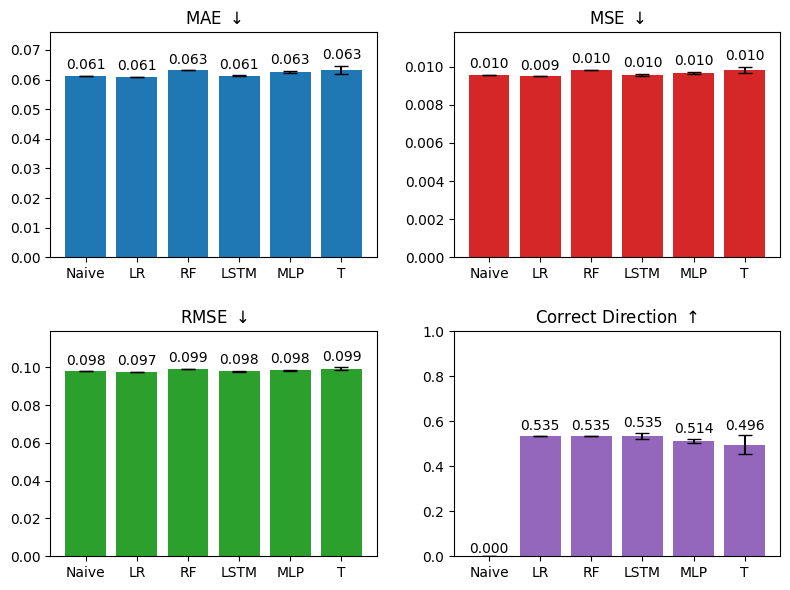

In [98]:
def compute_mean_and_sem(results_by_seed, metric):
    # Create a dict: { model_name: [metric_values_across_seeds] }
    aggregated = defaultdict(list)
    
    for seed_results in results_by_seed.values():
        for model_name, metrics in seed_results.items():
            aggregated[model_name].append(metrics[metric])
    
    # Compute mean and SEM
    means = {k: np.mean(v) for k, v in aggregated.items()}
    sems = {k: np.std(v, ddof=1) / np.sqrt(len(v)) for k, v in aggregated.items()}
    
    return means, sems

def plot_bar(ax, means: dict, sems: dict, title: str, color: str = 'tab:blue'):
    labels = list(means.keys())
    values = list(means.values())
    errors = [sems[k] for k in labels]

    bar = ax.bar(labels, values, yerr=errors, capsize=5, color=color)

    # Add the value labels on top of each bar
    for rect, mean, sem in zip(bar, values, sems.values()):
        height = mean * 1.02 + sem
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{mean:.3f}', ha='center', va='bottom')

    ax.set_title(title)
    ax.set_ylim(0, max(values) * 1.2)

fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Metrics to plot
metrics_info = [
    ('mae', 'MAE' + r' $\downarrow$', 'tab:blue'),
    ('mse', 'MSE' + r' $\downarrow$', 'tab:red'),
    ('rmse', 'RMSE' + r' $\downarrow$', 'tab:green'),
    ('corr_dir', 'Correct Direction' + r' $\uparrow$', 'tab:purple'),
]

# Plot MAE, MSE, RMSE, and Correct Direction metrics in a 2x2 grid
for i, (metric, title, color) in enumerate(metrics_info):
    means, sems = compute_mean_and_sem(results_by_seed, metric)
    row, col = divmod(i, 2)
    plot_bar(ax[row, col], means, sems, title, color=color)
    if metric == 'corr_dir':
        ax[row, col].set_ylim(0, 1)

plt.tight_layout(w_pad=2, h_pad=2)
plt.show()

Alright, here comes the reality check. I hope you weren’t expecting anything crazy, because the results say otherwise. From the simple naive model all the way to the transformer, the MAE numbers are pretty much the same. No big difference there. The only metric that makes a bit of sense is the “correct direction,” which is zero for the naive model since it doesn’t actually try to predict if the price goes up or down. The other models hover around 50%, which basically means they’re guessing the direction as well as flipping a coin. The other metrics are just as low across the board.

So what does this mean? Either the models weren’t trained properly or didn’t have enough data (which seems unlikely here), or, more likely, the closing prices alone just don’t hold enough clues to make accurate predictions. Bit of a bummer, but that’s the reality.

If you want to take a look at some price predictions over time for a specific stock, I’ve got you covered:

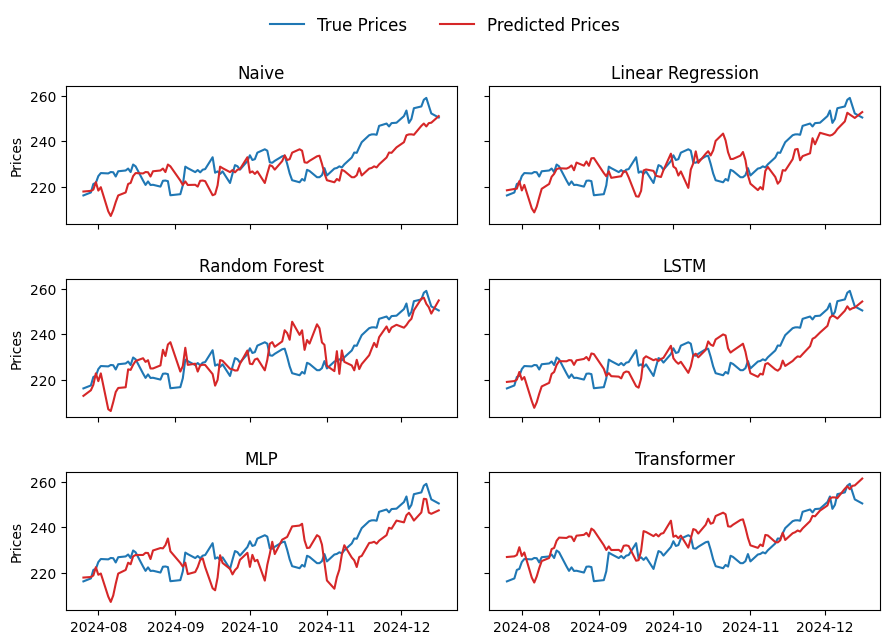

In [99]:
test_dates = sup_df['date'].unique()[-len(y_test):]
symbol = "AAPL"

# Filter the DataFrame for the specific symbol and the last 100 dates
symbol_df = sup_df[sup_df['symbol'] == symbol].iloc[-100:]
symbol_dates = symbol_df['date'].unique()

X_symbol = symbol_df[ret_cols].values
X_symbol_scaled = scaler.transform(X_symbol)

y_symbol = symbol_df['target'].values
prices = symbol_df['price'].values

fig, axs = plt.subplots(len(models) // 2, 2, figsize=(9, 6), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Loop over each model to plot predictions vs true prices
for i, model in enumerate(models):
    y_pred_symbol = model.predict(X_symbol_scaled)
    
    price_y_pred = prices * (1 + y_pred_symbol)
    prices_y = prices * (1 + y_symbol)
    x_axis = pd.to_datetime(symbol_dates)
    
    axs[i].plot(x_axis, prices_y, label='True Prices' if i == 0 else None, color='tab:blue')
    axs[i].plot(x_axis, price_y_pred, label='Predicted Prices' if i == 0 else None, color='tab:red')
    
    axs[i].set_title(f'{model.name}')
    if i % 2 == 0:
        axs[i].set_ylabel('Prices')

# Add a single legend above all plots, with no frame and larger font size
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=False, fontsize='large')

plt.tight_layout(w_pad=2.0, h_pad=2.0)
plt.show()

You’ll notice that most of the predictions just lag behind the actual curve, basically following the true prices, but with a 10-day delay. This is something you’ll often see in many articles, except they usually use a 1-day forecast, which can misleadingly make the model look perfect. But in reality, it’s not performing as well as it seems.

## So... is it all hopeless?

Not quite, but let’s be honest: trying to forecast the market using just the closing price might be no better than rolling a dice. You can experiment by adding open, high, low, and volume, but chances are, it won’t drastically change the outcome. And indicators? Sure, they might help a bit, but in the end, they’re just nonlinear combinations of those same variables. I’m not saying they’re useless, just don’t expect miracles.

So, am I saying it’s impossible to predict the market? Definitely not. But I am saying that freely available data like this is... well, freely available for a reason. If you really want to move the needle, you probably need access to richer, harder-to-get data. Think sentiment, fundamentals, financial reports, macro stuff. The kind of data that’s not sitting in a CSV file online.

That said, even if the predictions don’t blow your mind, this kind of project is still one of the coolest ways to dive into machine learning, data science, and finance all at once. So seriously, go explore, test things, tweak models. It’s a great learning experience.

Tiny disclaimer before I wrap up: I’m one of the co-founders of [Zelyos](https://zelyos.com/), an AI-powered stock picker that focuses exactly on this: bringing in the not-so-easy-to-find data to build better forecasts. So of course, I’m biased. But I’m also just sharing the lessons we’ve learned from building and experimenting. And hey, I genuinely hope you don’t fully agree with me. I’d love to hear your take.

> None of this is financial advice. I’m pretty sure by now it’s clear that it’s not nearly enough to rely on. This is all for learning and exploration, nothing more.

Thanks so much for reading. I hope you had fun, and I’d really love to hear your thoughts!